In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [17]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9189226527875557
0.8698779253276527
0.7566303173418913
1.1913424214693298
0.9953424146502148


In [53]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'SCHD', 'SPY', 'TLT']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  4 of 4 completed


In [54]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'S&P500', 'SPY')
df_imp = myfuncs.imputation(df_imp, 'Div', 'SCHD')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')


## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.0449080408162759
0.9936317587295975
0.9943534215384441
-0.4193288240664953


In [55]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Visualization

In [56]:
## assets = ['JEPQ', 'QQQ']
assets = ['QQQ', 'SPY', 'SCHD']

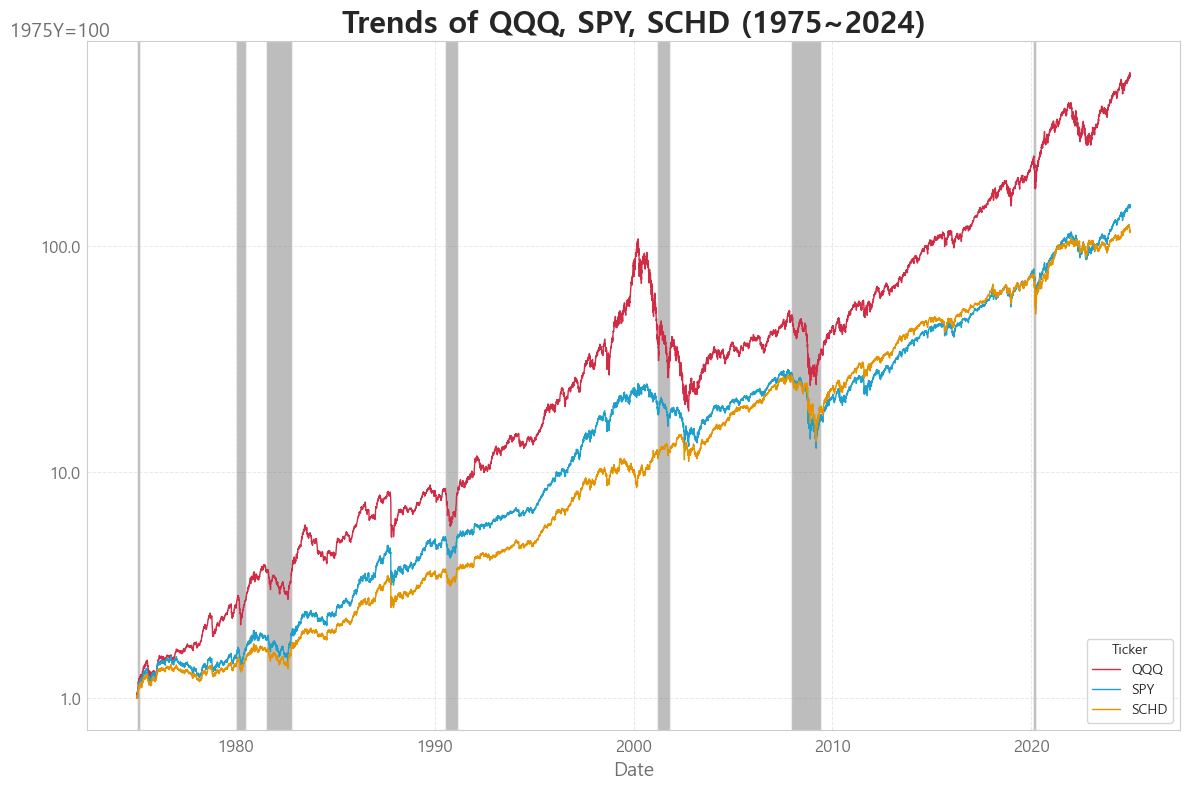

In [57]:
gm.trend_plot(df_imp, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

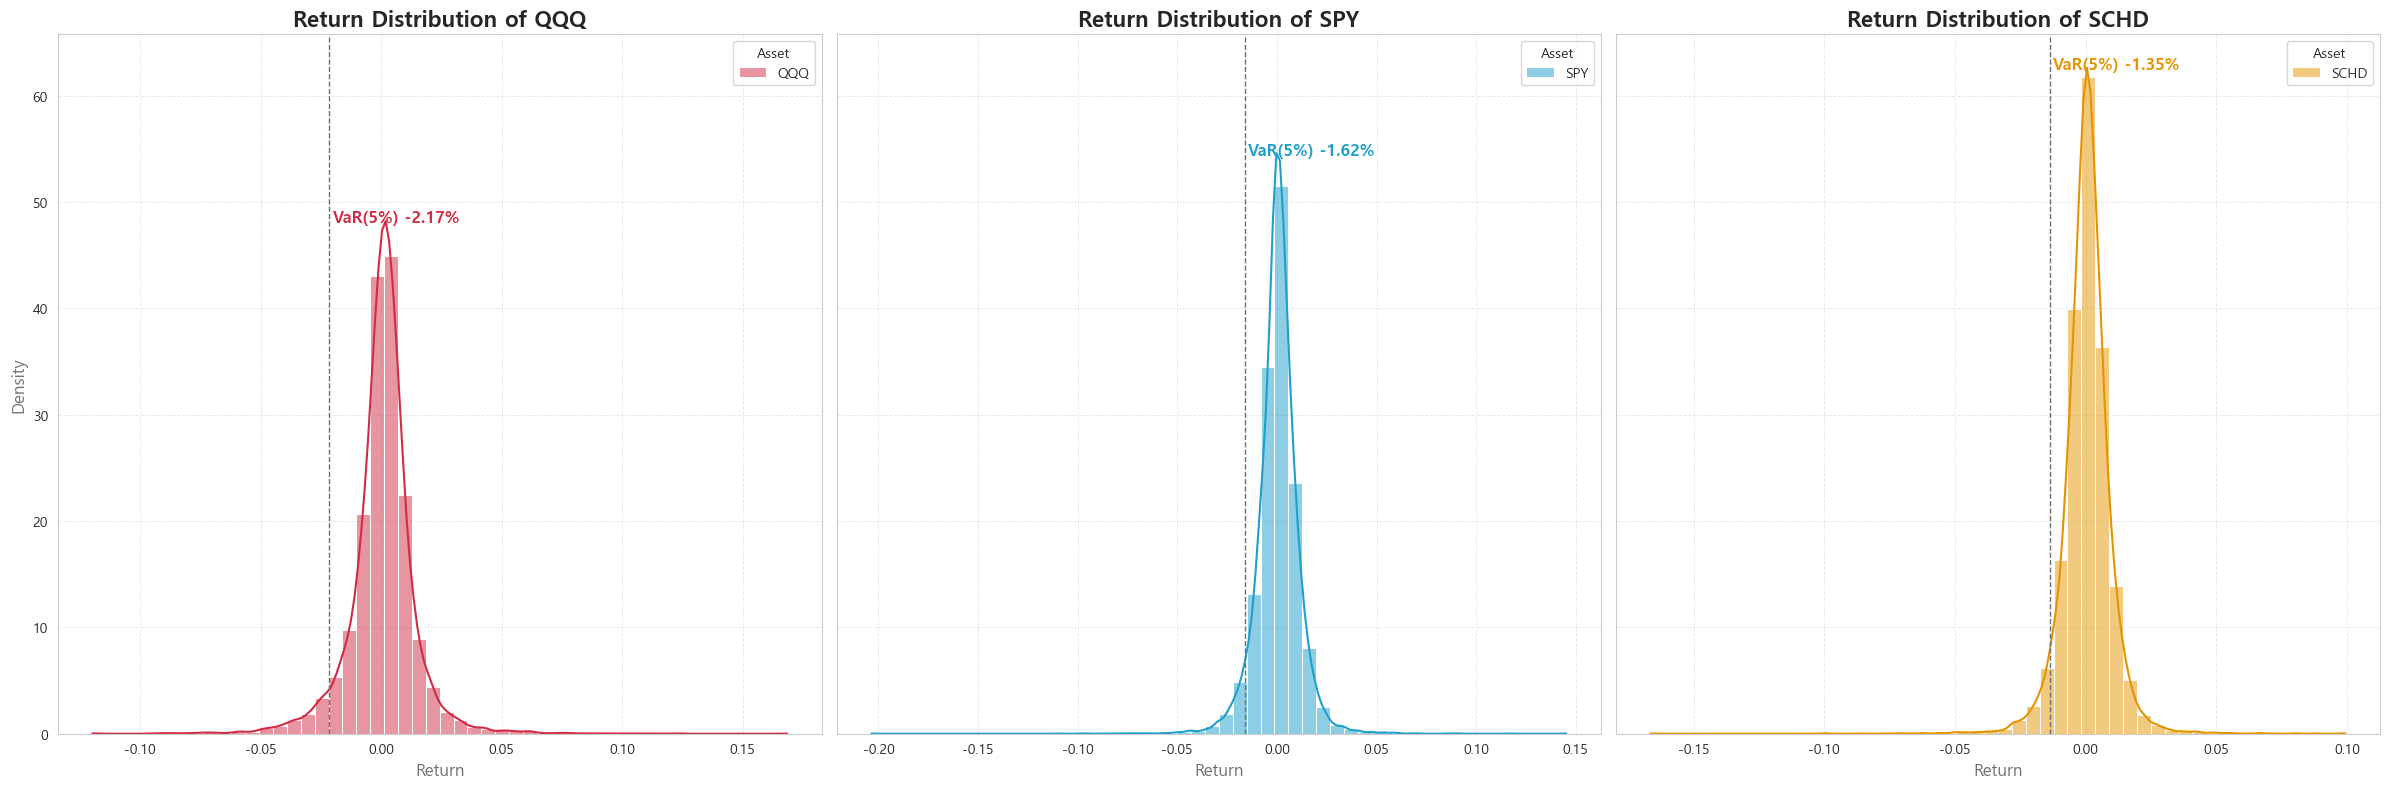

In [58]:
gm.asset_histogram_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

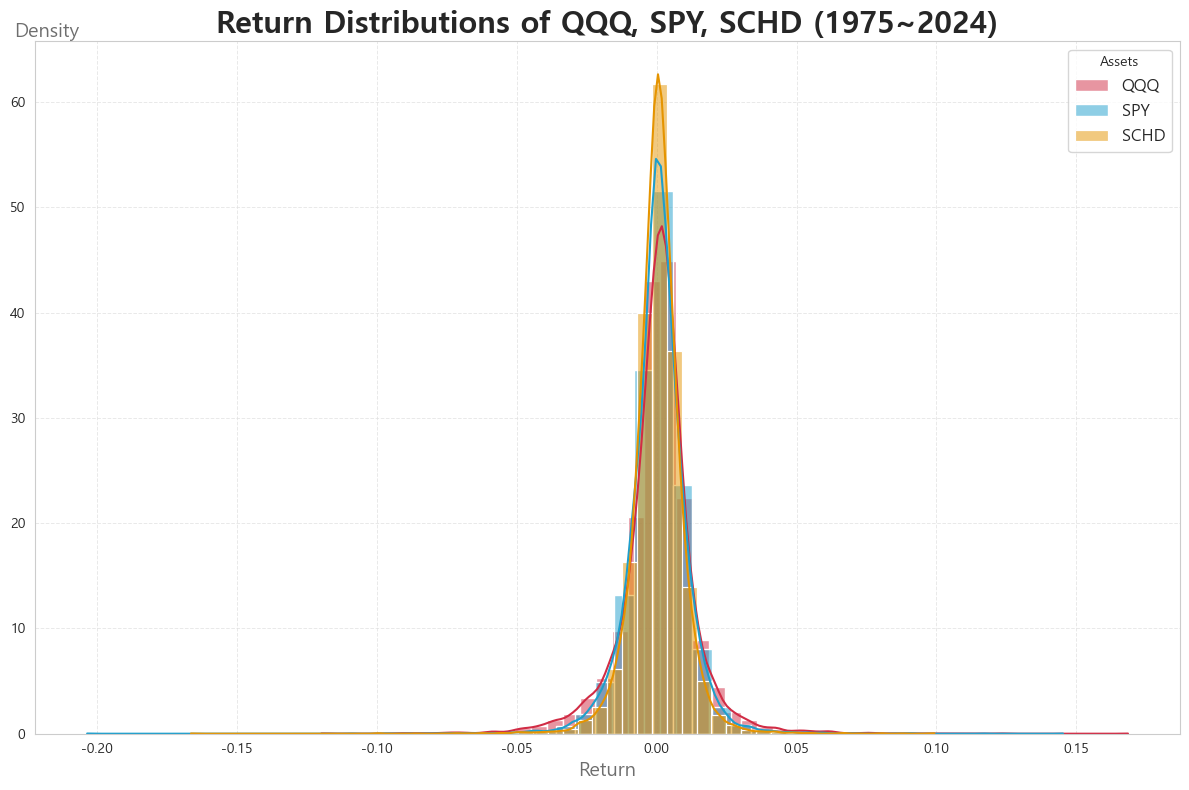

In [59]:
gm.asset_histogram_merged_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

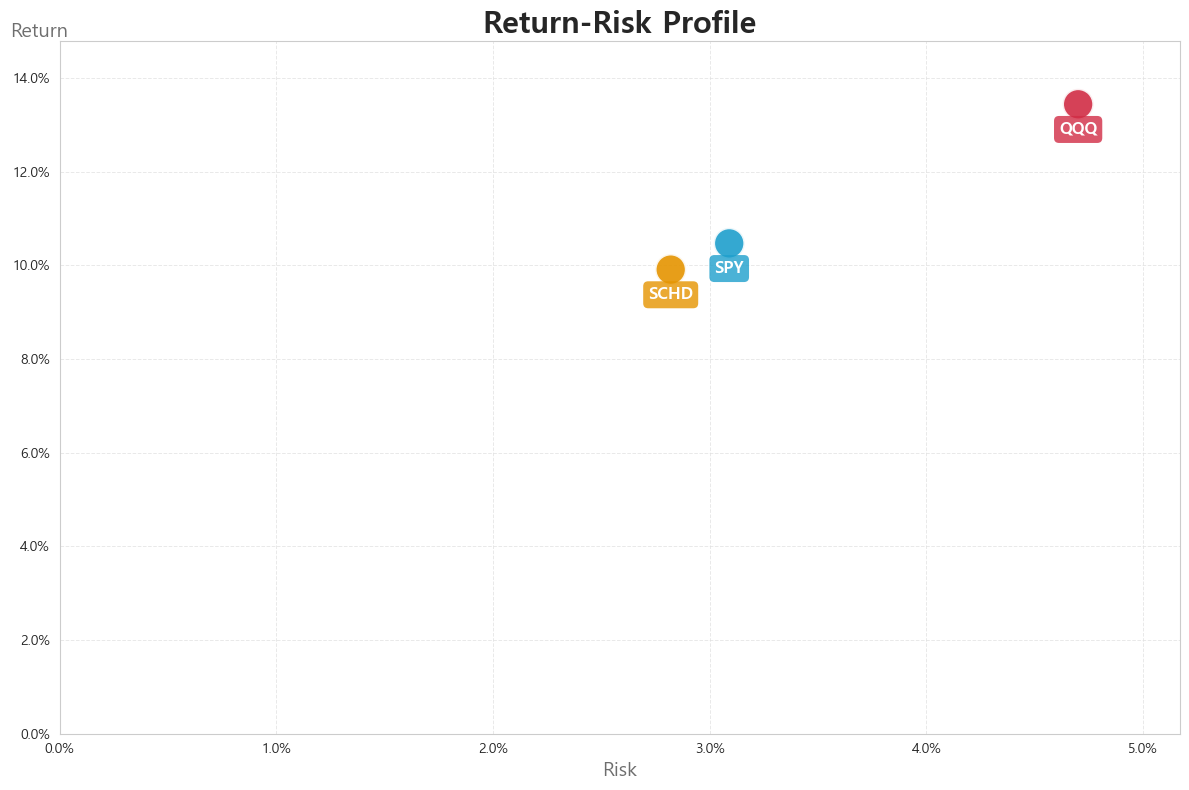

In [60]:
return_risk_df = anal_funcs.get_Vol_report(df_imp[assets], method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

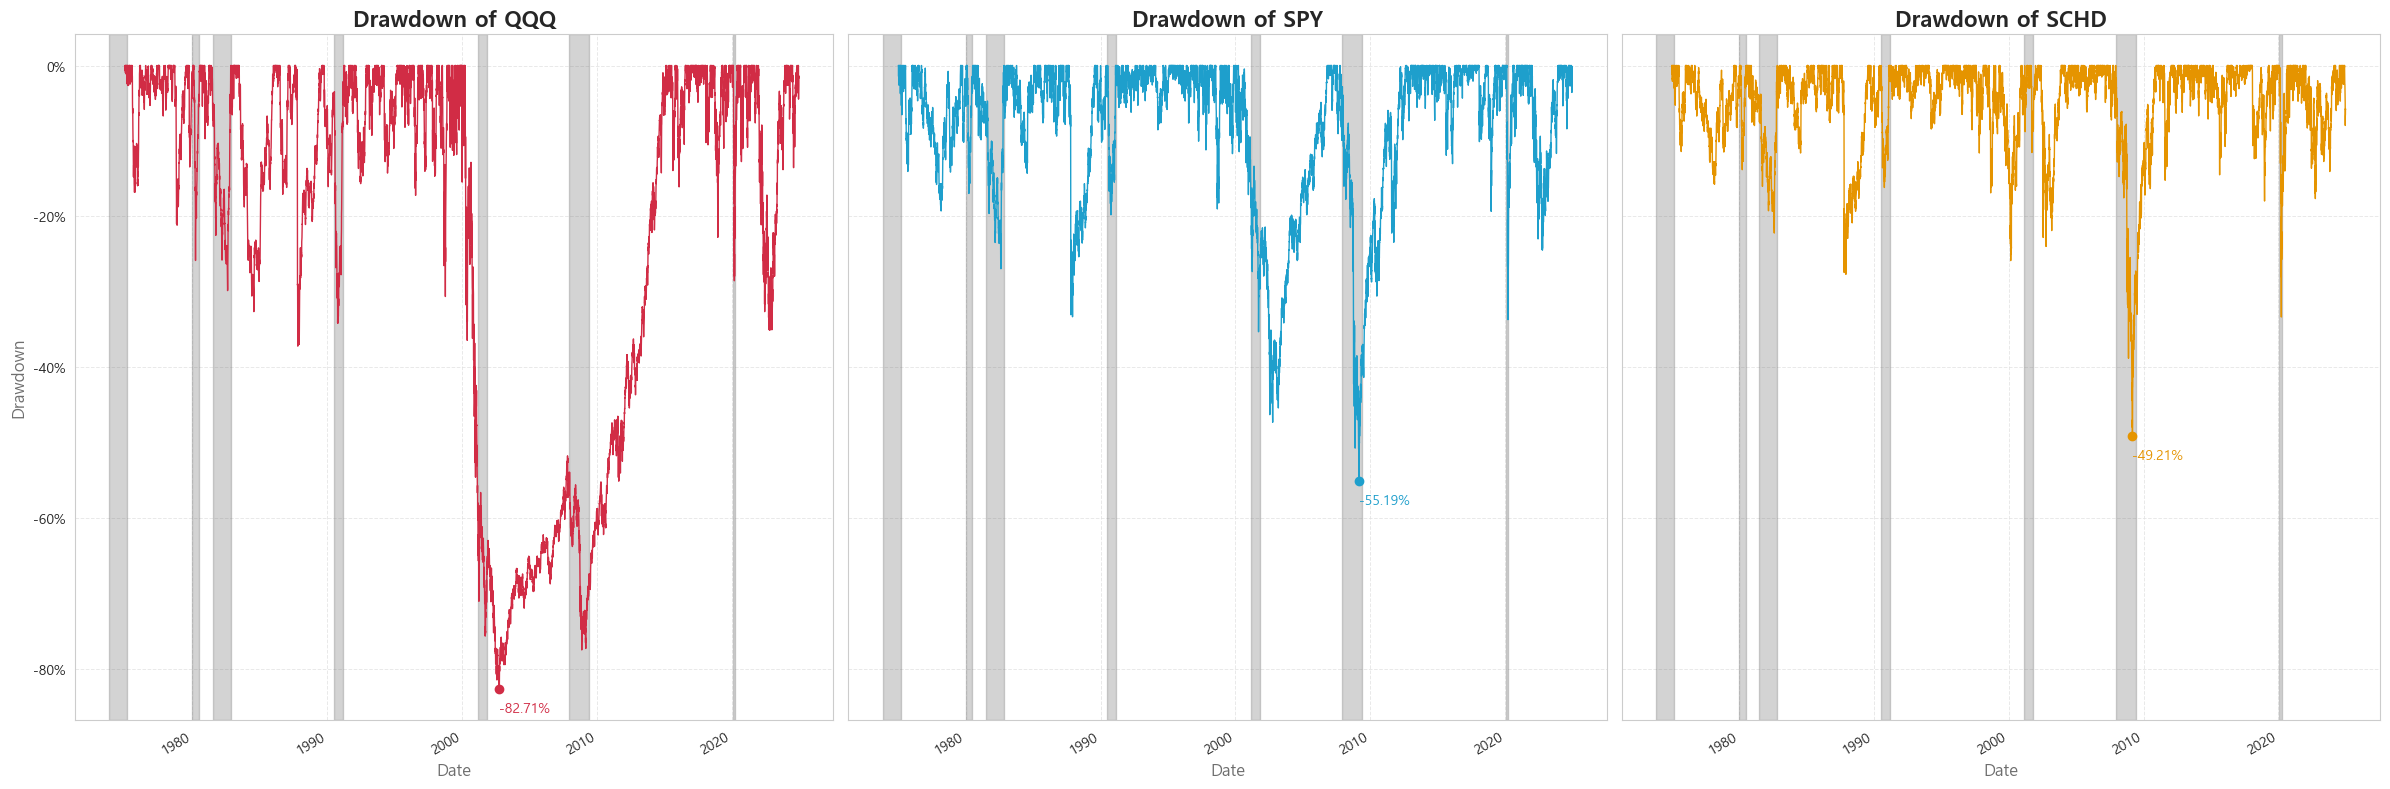

In [61]:
gm.drawdown_plot(df_imp, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

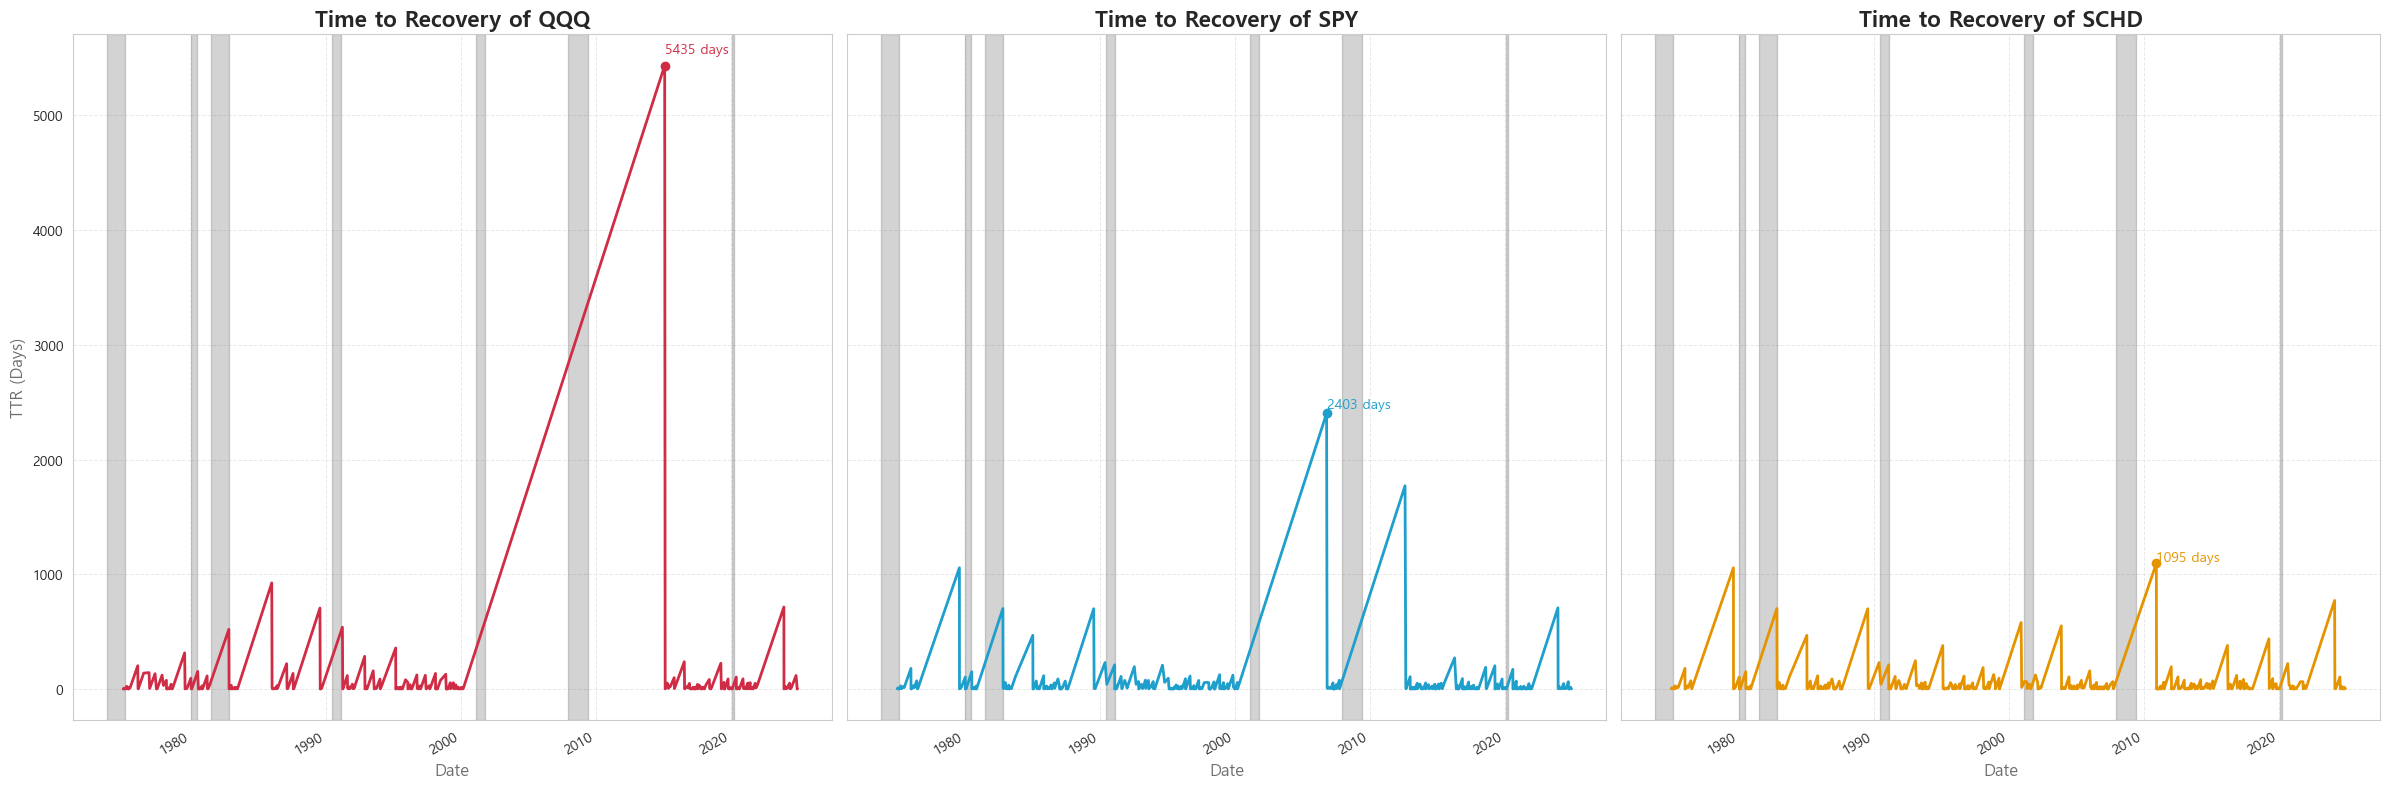

In [62]:
ttr_df = myfuncs.get_ttr_df(df_imp, assets)
gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

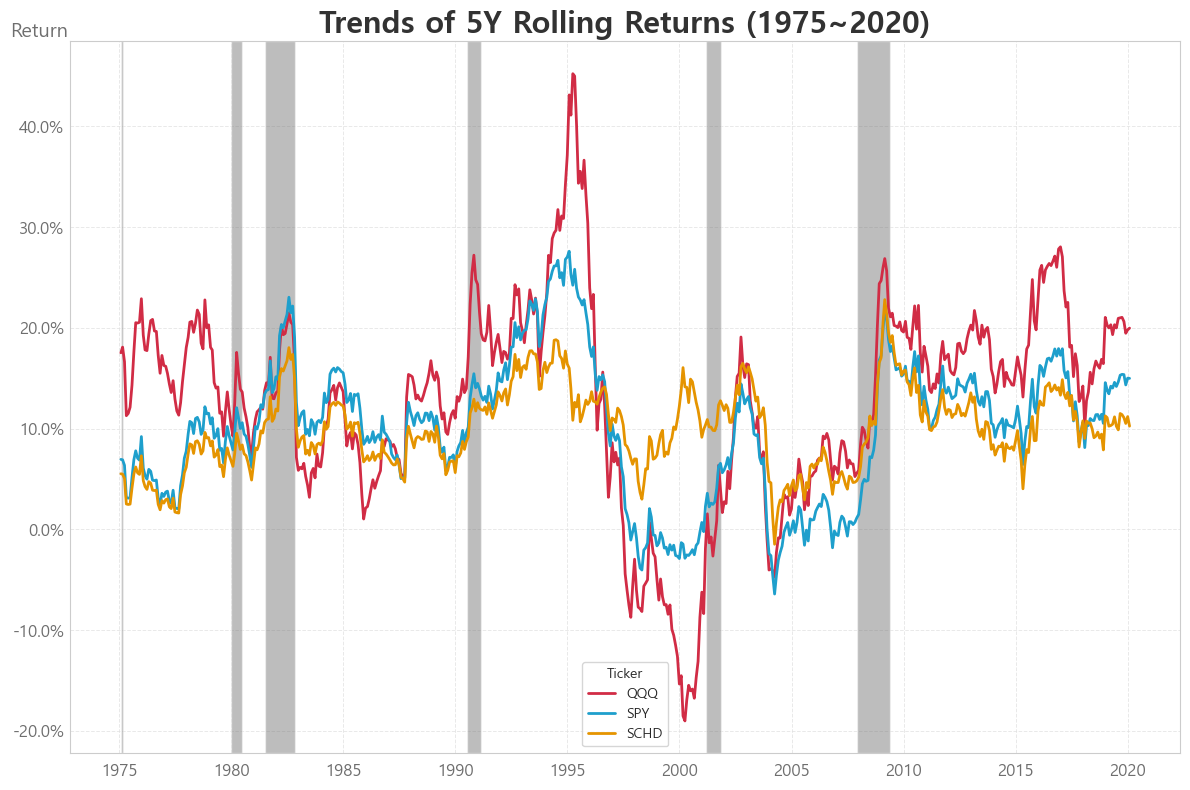

In [63]:
rr_df = myfuncs.get_rr_df(df_imp, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

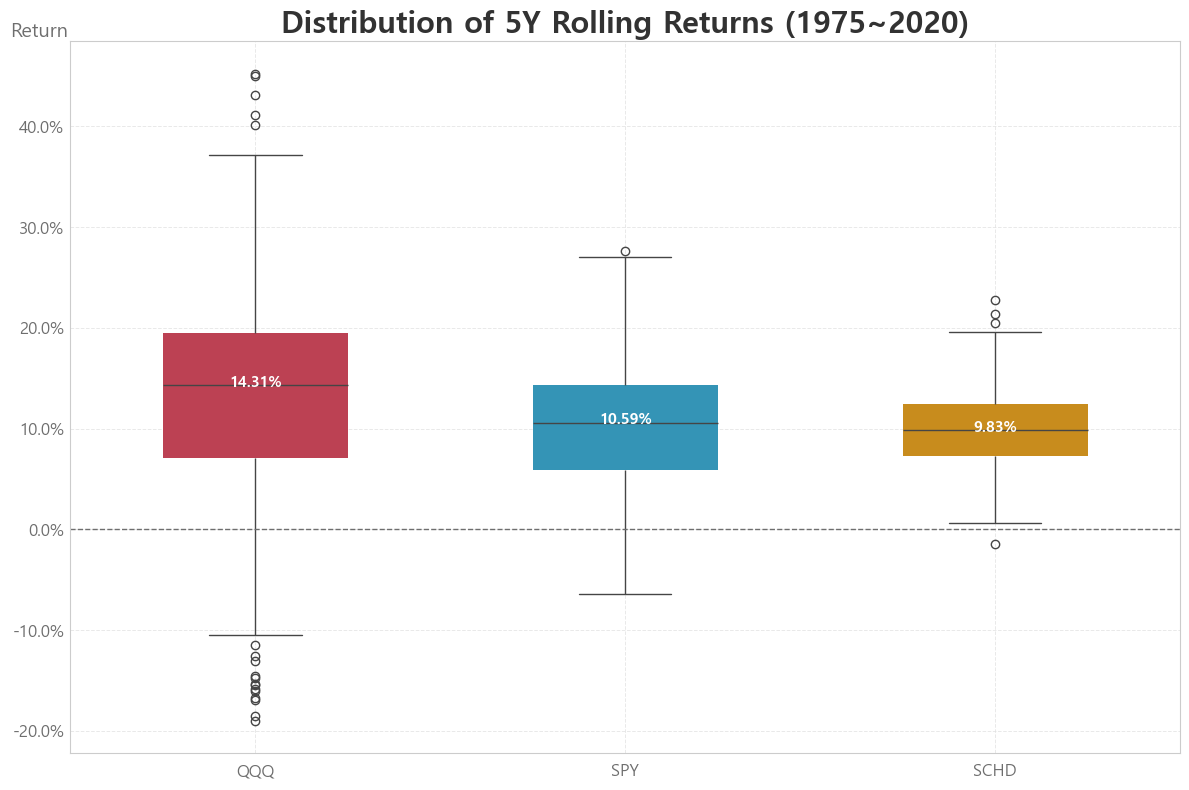

In [64]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [65]:
corr_df = df_imp.pct_change()[['QQQ', 'SPY', 'SCHD', 'TLT', 'Gold']].corr()

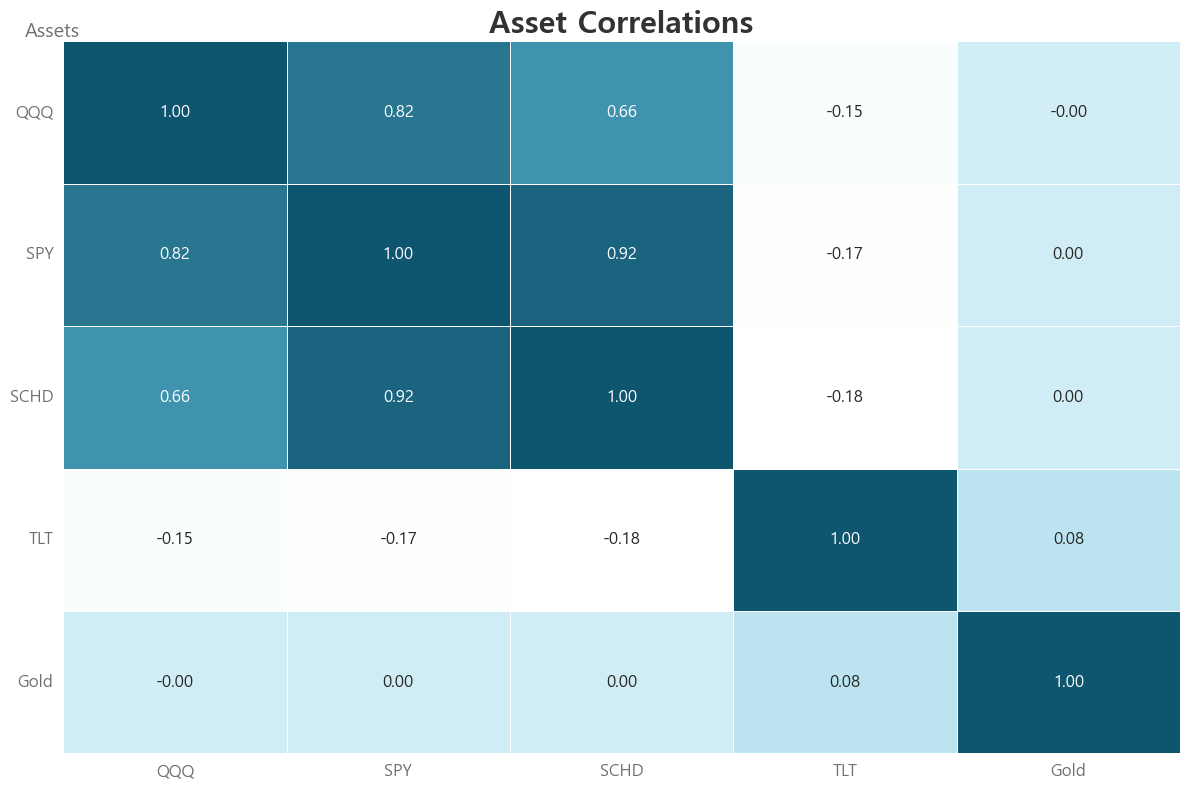

In [66]:
gm.corr_plot(corr_df, cmap=custom_cmap)

## Optimization

In [67]:
df_imp_m = df_imp[assets].resample('M').last()

In [68]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [69]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=5, min_edge=0)

총 231번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중


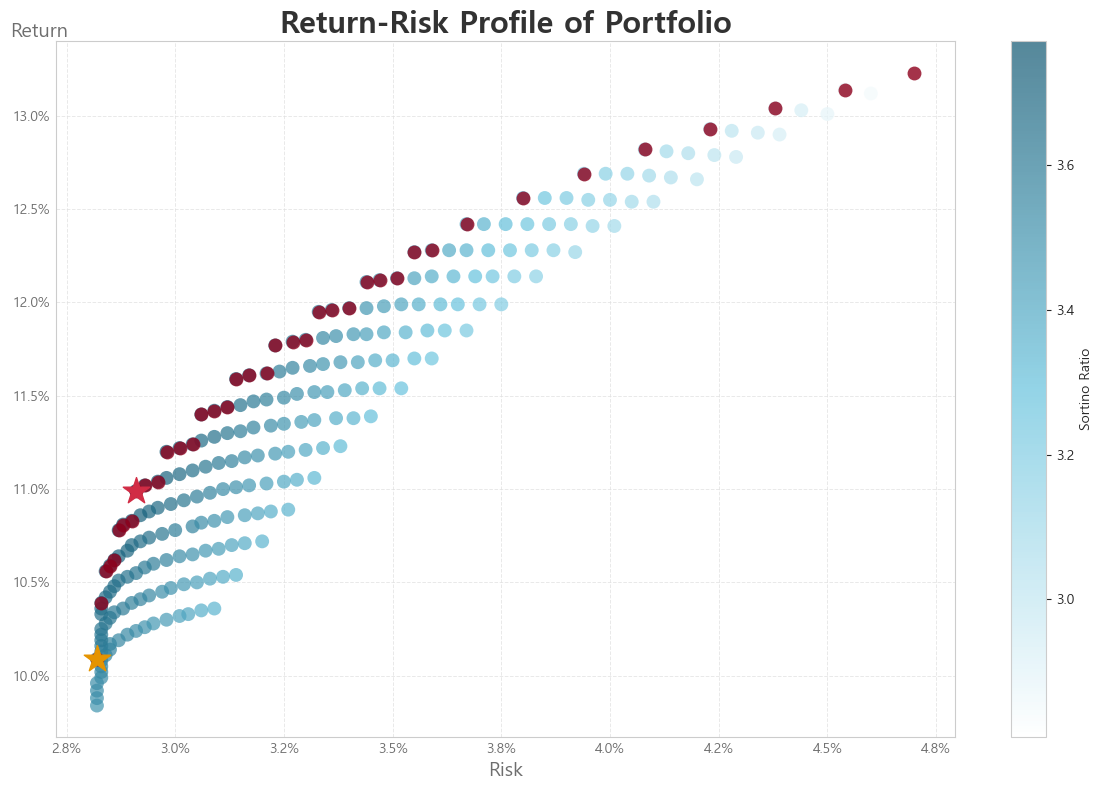

In [70]:
gm.portfilio_return_risk_profile_plot(process, obtimal, min_risk, cmap=custom_cmap)

In [71]:
process[process['Point'] == 'Obtimal']

,QQQ,SPY,SCHD,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio,Point,Efficient
95,0.25,0.0,0.75,10.99,4.03,2.91,2.73,3.77,Obtimal,True


In [72]:
## ratio 임의 조정시
ratio = [0.25, 0, 0.75]
result = allocator.cal_rebalancing(df_imp_m, ratio=ratio, rebalancing='m', unit='monthly')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

In [75]:
port_ssets = ['Portfolio'] + assets
port_ssets_sp = ['Portfolio', 'SCHD']

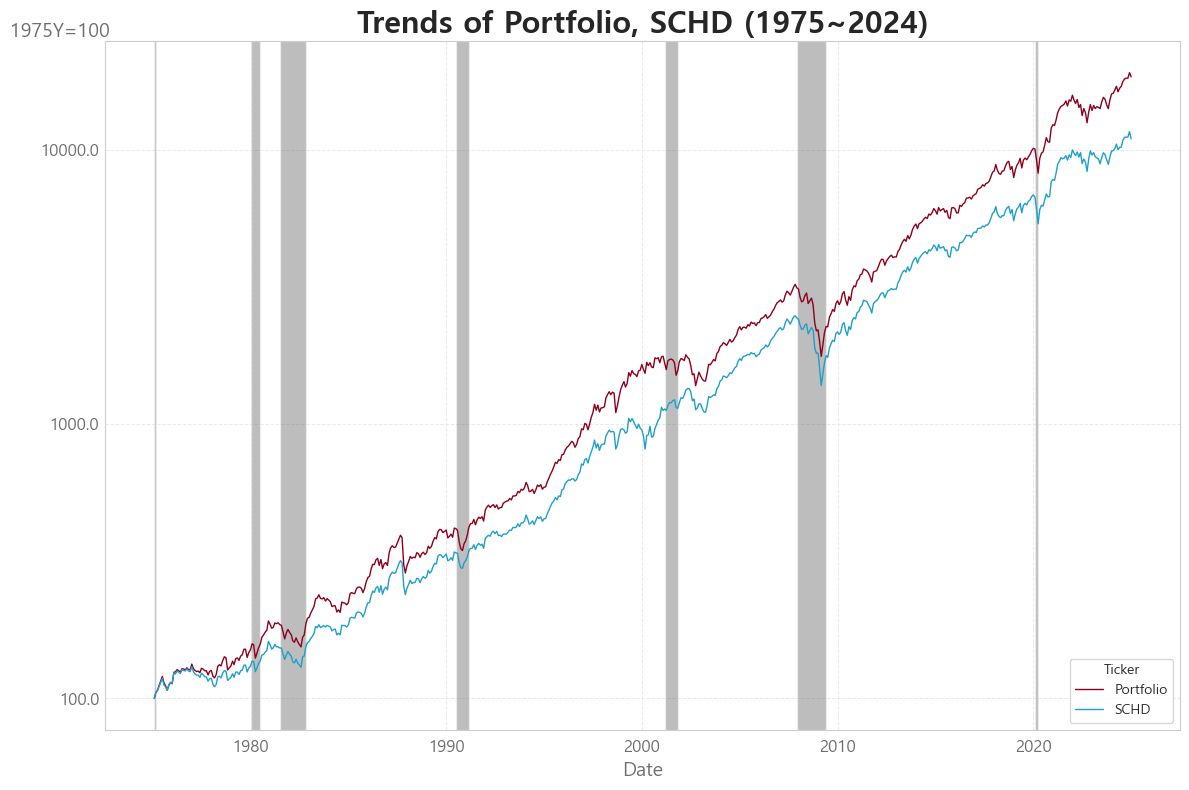

In [76]:
gm.trend_plot(result, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

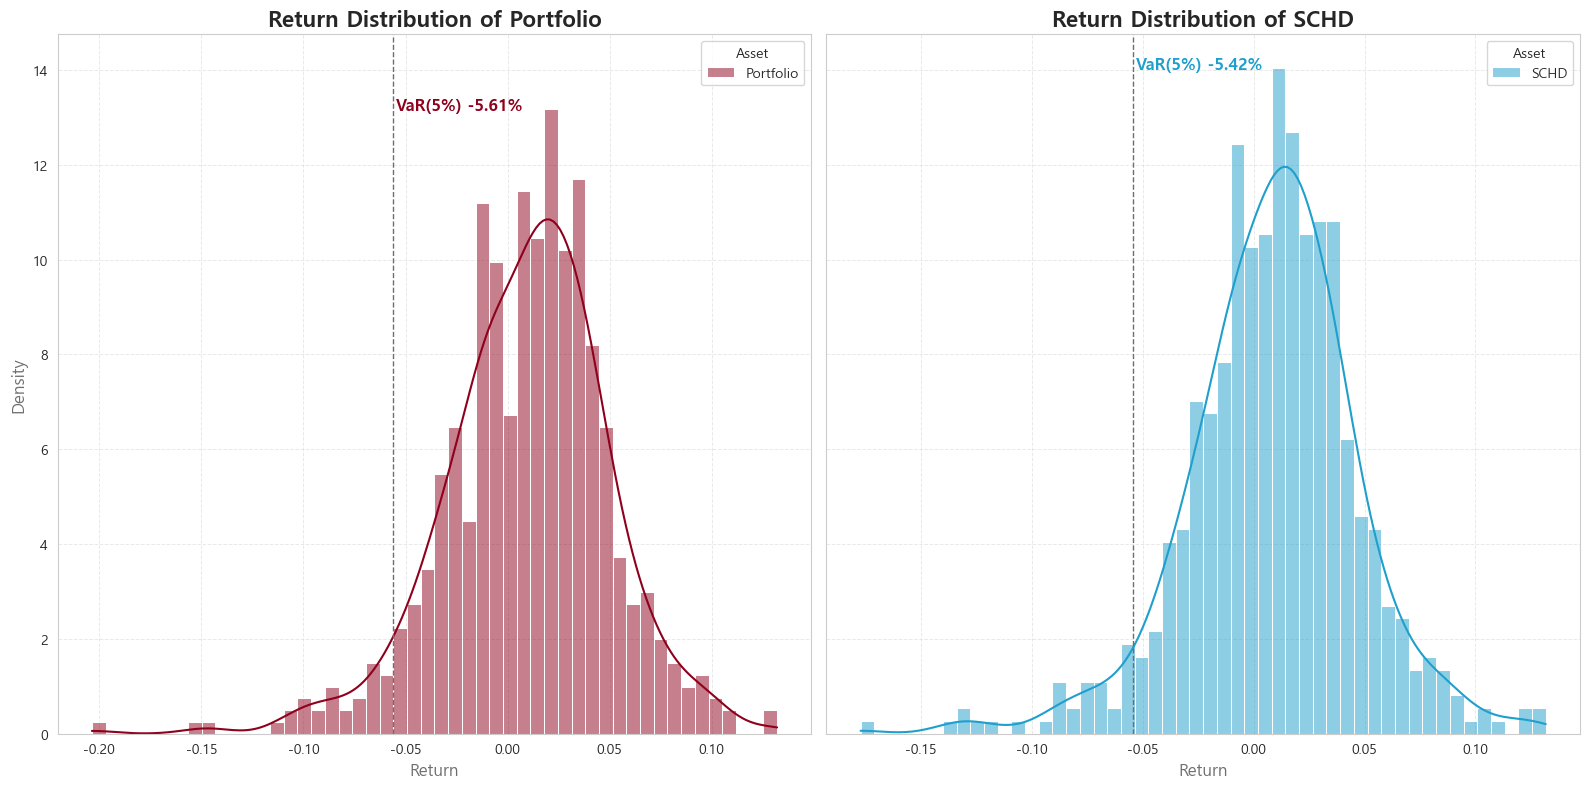

In [77]:
gm.asset_histogram_plot(result.pct_change(), port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

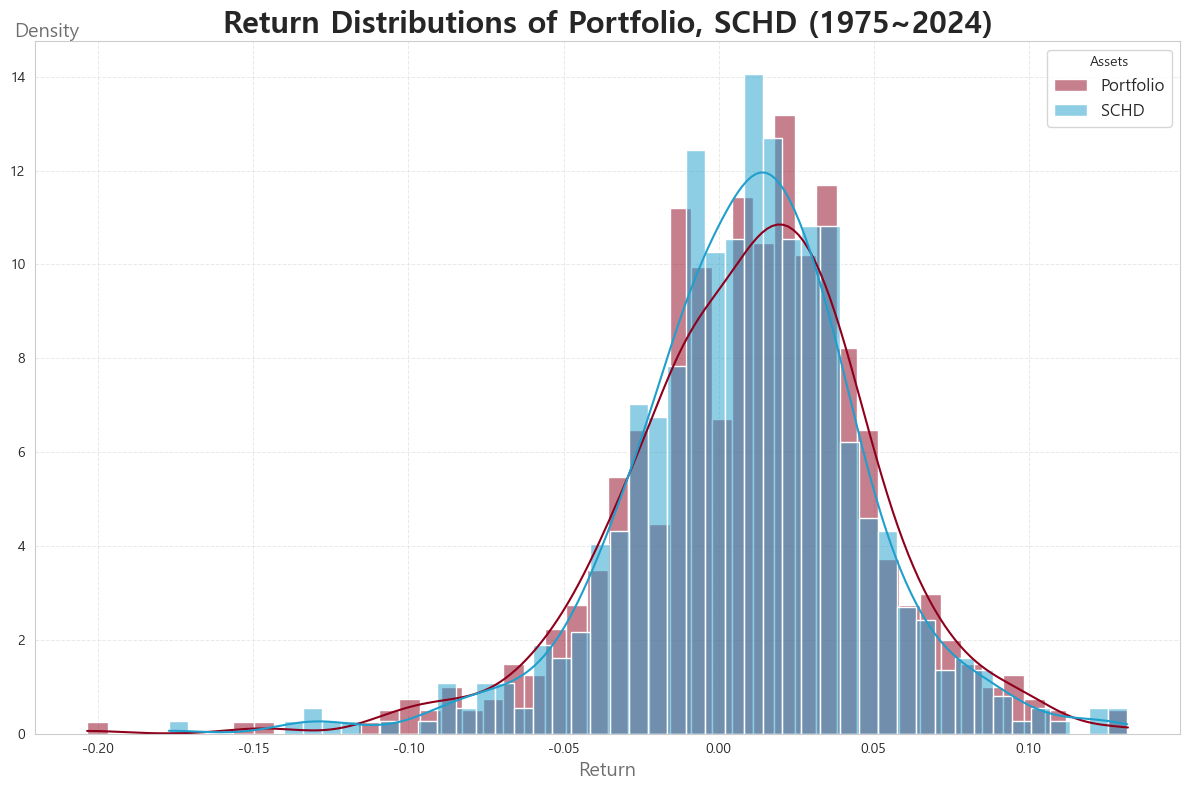

In [78]:
gm.asset_histogram_merged_plot(result.pct_change(), port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

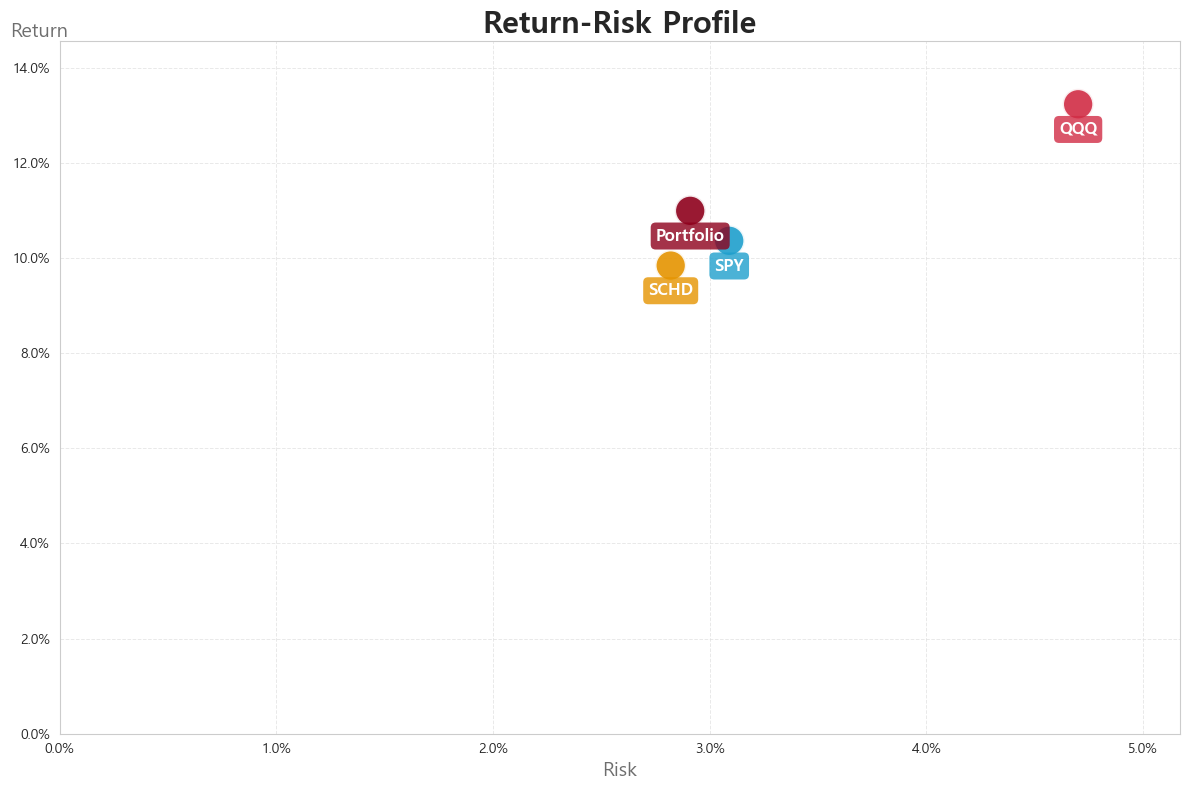

In [79]:
return_risk_df = anal_funcs.get_Vol_report(result[port_ssets], unit='monthly', method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, port_ssets, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

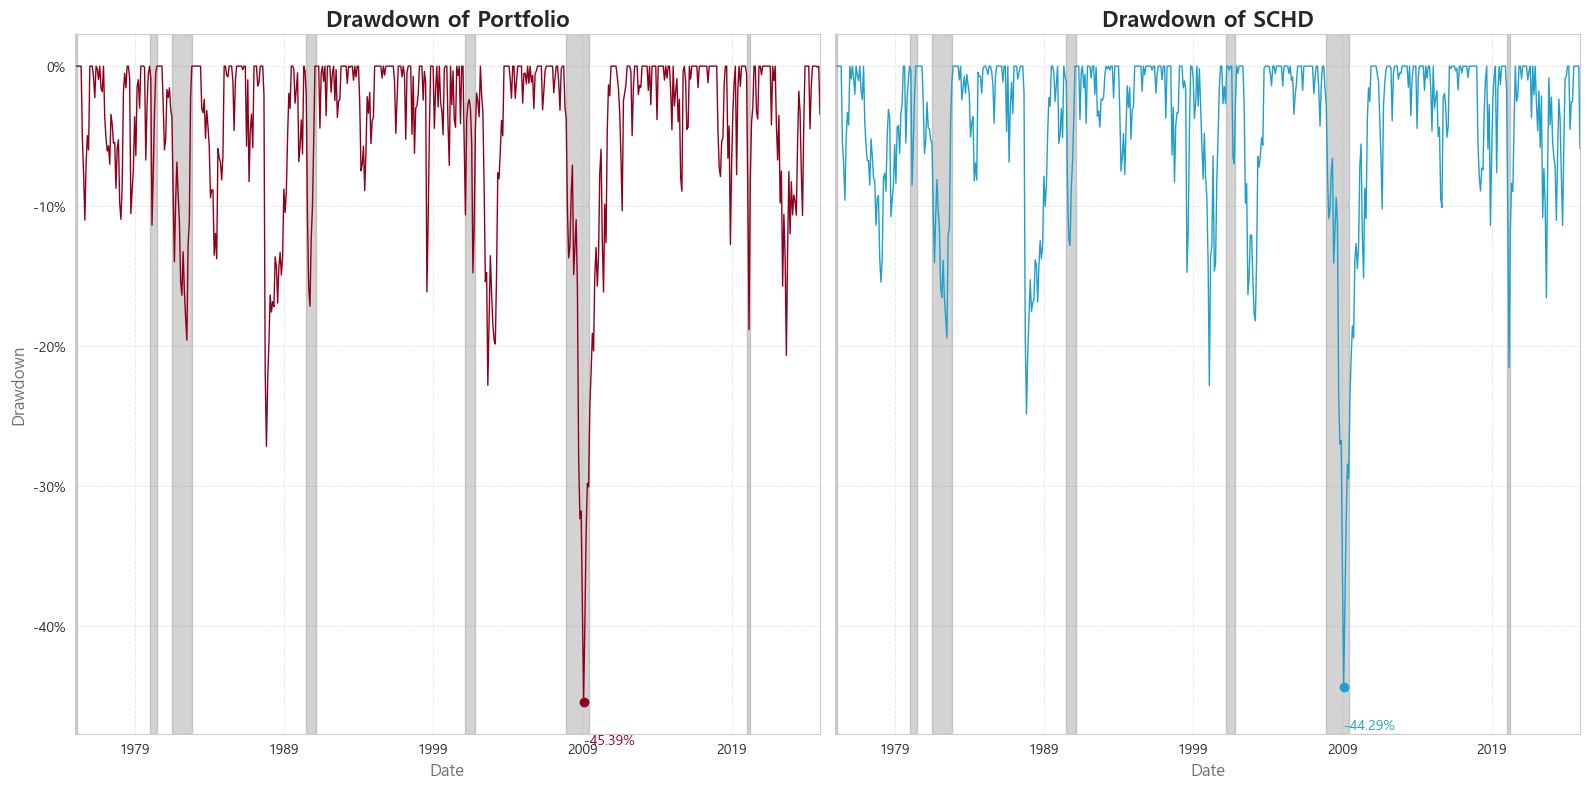

In [80]:
gm.drawdown_plot(result, port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

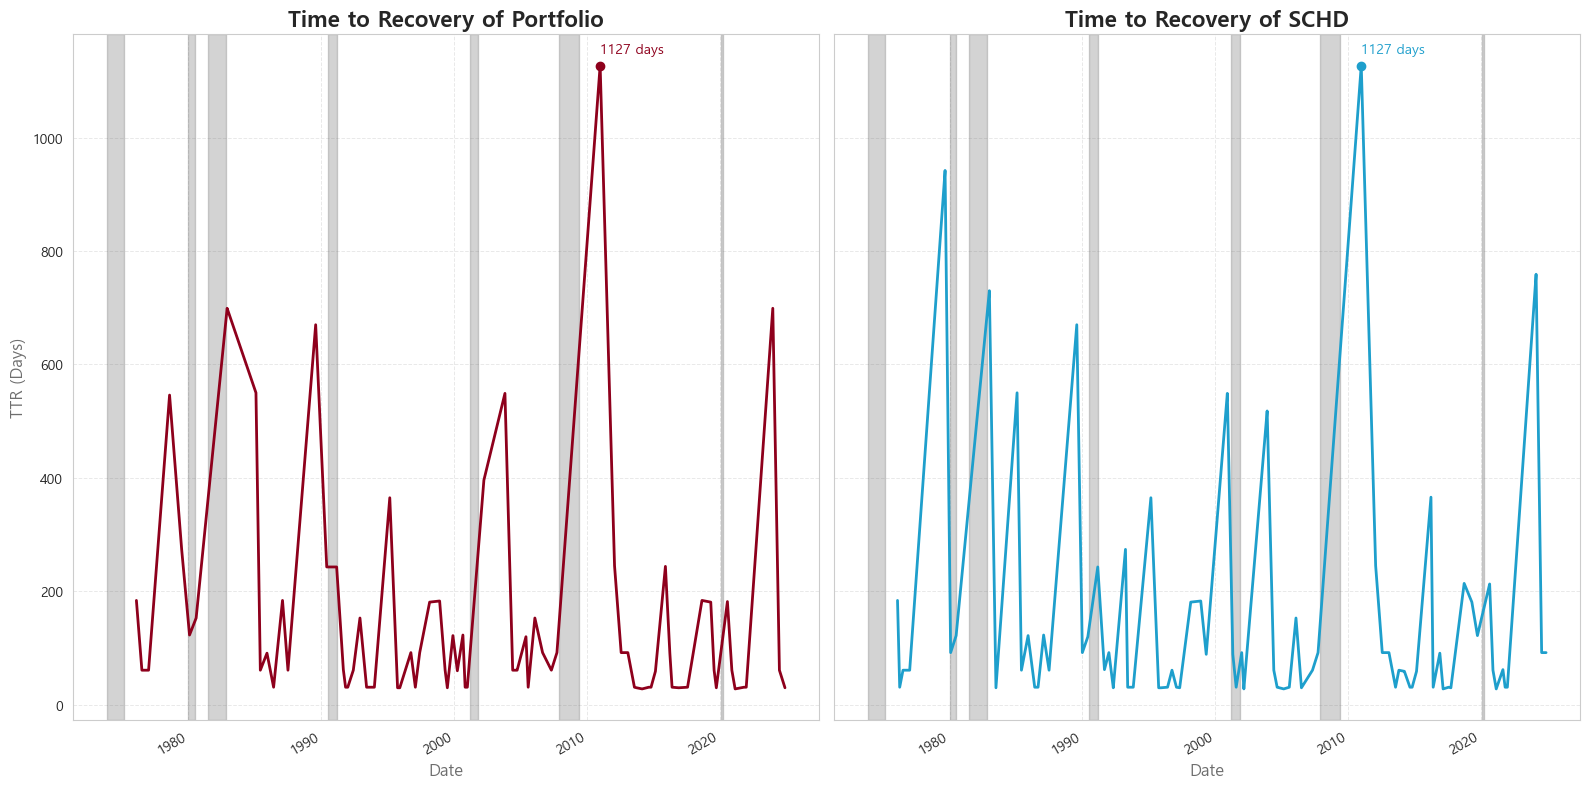

In [81]:
ttr_df = myfuncs.get_ttr_df(result, port_ssets_sp)
gm.ttr_plot(ttr_df, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

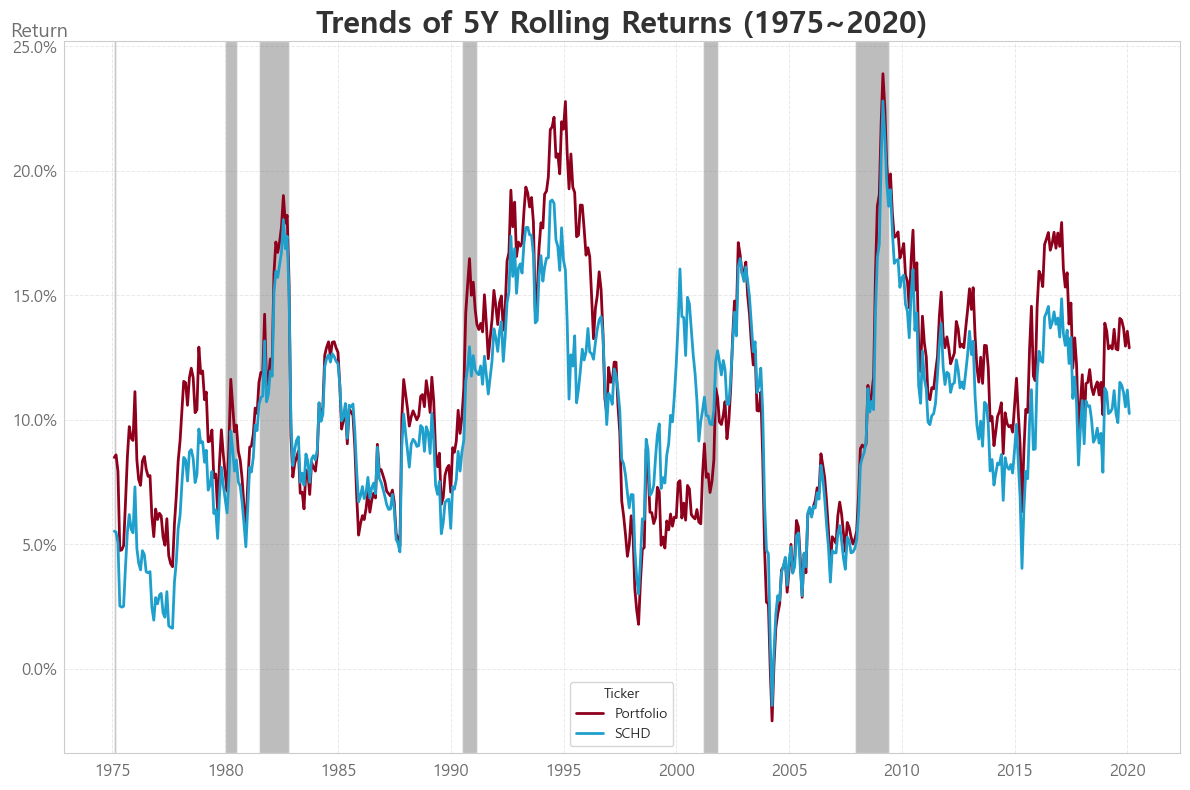

In [82]:
rr_df = myfuncs.get_rr_df(result, port_ssets_sp)
gm.rr_trend_plot(rr_df, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

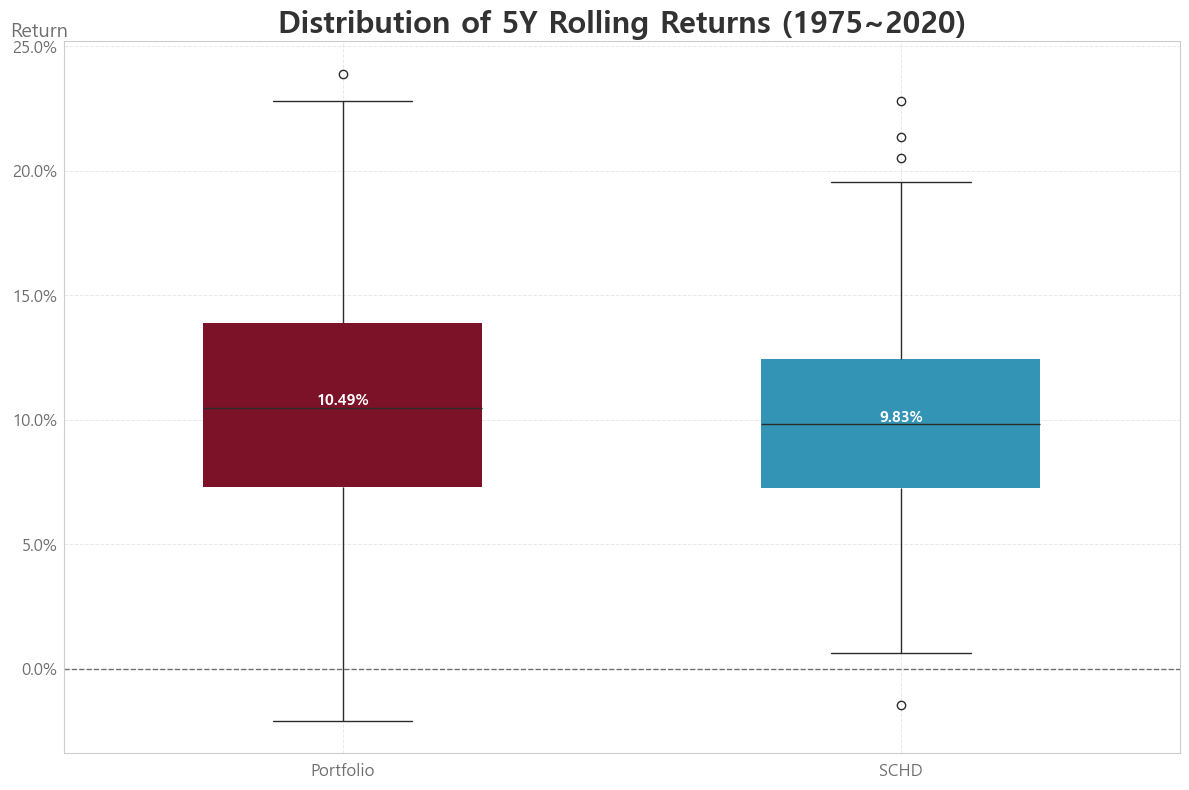

In [83]:
gm.rr_box_plot(rr_df, port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

In [84]:
rr_df['Portfolio'].describe()

count    541.000000
mean      10.903275
std        4.531508
min       -2.097804
25%        7.286184
50%       10.487049
75%       13.868573
max       23.899395
Name: Portfolio, dtype: float64

In [87]:
rr_df['SCHD'].describe()

count    541.000000
mean       9.925654
std        3.943064
min       -1.475311
25%        7.237892
50%        9.833290
75%       12.453605
max       22.805786
Name: SCHD, dtype: float64